## Задание
 Построение модели линейной регрессии, настройка гиперпараметров на кросс-валидации, интерпретация коэффициентов.

## Цель: 
В этом дз вы потренируетесь строить интерпретируемые модели линейной регрессии с регуляризацией и без. Снова пройдемся по основным этапам работы с данными и на выходе получим модели, способные предсказывать цены на жильё в AirBnb.
Снова предсказание цены квартиры, но на сей раз съемной :)

1. Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

2. Пройдите по основным шагам работы с данными - базовые статистики, визуализации (распределения, корреляции, pair plots), предобработка переменных.

`Переменные, которые пока нужно убрать: id, name, host_id, host_name, last_review.`

Обратите внимание на распределение целевой переменной.

Во время предобработки не забудьте закодировать категориальные переменные (one-hot encoding, можно использовать pd.get_dummies) и прошкалировать непрерывные.

Бонусное задание по предобработке - найдите координаты центра Нью-Йорка и при помощи евклидового расстояния создайте новую переменную "center_distance" используя широту и долготу центра и текущей квартиры. Этот признак для линейной регрессии будет работать гораздо лучше, чем просто широта и долгота, так что их можно будет спокойно убрать из датасета.

3. Отложите 30% данных для тестирования и постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV. Измерьте качество каждой и визуализируйте важность признаков. Сделайте интересные выводы :) 

In [363]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже знакомый вам пакет для картинок 
import matplotlib as mplt
import seaborn as sns             # ещё один пакет для картинок 
import math

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# EDA

Загрузим датасет и посмотрим на данные

In [868]:
df = pd.read_csv('data/AB_NYC_2019.csv')  # подгружаем табличку 
print('Размер выборки:', df.shape)                          # смотрим на её размеры 
df.head( ) # Смотрим что лежит в табличке 

Размер выборки: (48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


В соответствии с заданием удаляем признаки:
`id, name, host_id, host_name, last_review`.

In [869]:
df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'], inplace=True)

## 1. Анализ целевой переменной

Целевой переменной является `price` - цена аренды за сутки. Выведем ее гистограмму.

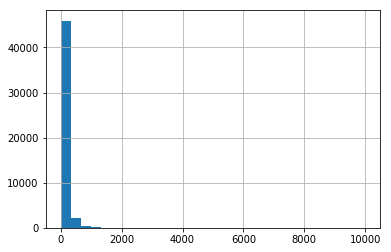

In [870]:
df['price'].hist(bins=30)

Из графика видно, что переменная имеет длинный "хвост" и принимает `нулевые!` значения.

Заменим значения `0` на `1` и проведем логарифмирование.

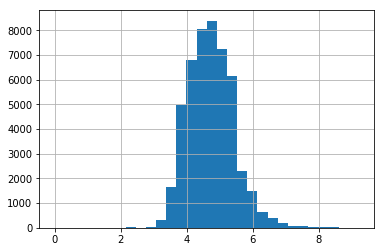

In [871]:
df['price'] = np.log(df['price'].apply(lambda x: 1 if x == 0 else x))
df['price'].hist(bins=30)

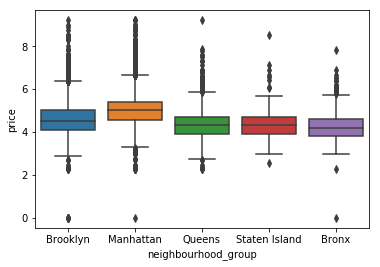

In [831]:
sns.boxplot( y="price", x="neighbourhood_group", data=df)

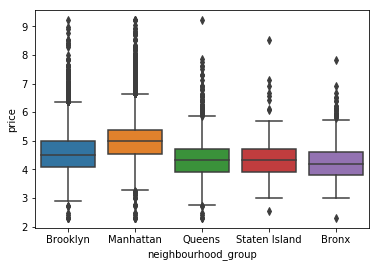

In [832]:
df = df[df['price'] != 0]
sns.boxplot( y="price", x="neighbourhood_group", data=df)

In [702]:
# df[df.index.isin([2202,5362,6524, 10345])]

# df.drop(index=[2202,5362,6524, 10345], inplace=True)

## 2. Анализ признаков

Проверим данные на пропуски:

In [872]:
df.info(verbose=True);

reviews_per_month_len = len(df[~df['reviews_per_month'].isna()])
df_len = len(df)

print("\nДанных в `reviews_per_month` меньше на {}% относительно остальных признаков.".format(
    round(100 - 100 * reviews_per_month_len / df_len))
     )

print('\nПосмотрим, есть ли в признаках пропуски:\n')
print(df.isnull().sum() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null float64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64
dtypes: float64(4), int64(4), object(3)
memory usage: 4.1+ MB

Данных в `reviews_per_month` меньше на 21% относительно остальных признаков.

Посмотрим, есть ли в признаках пропуски:

neighbourhood_group                   0
neighbourhood                         0
latitude    

Отсутствие 21% данных не является критичным. Также не обходимо заполнить пропуски в признаке `reviews_per_month`.

Посчитаем количество признаков по типам:

In [764]:
df.columns.to_series().groupby([df.dtypes,df.columns]).count()

int64    availability_365                  1
         calculated_host_listings_count    1
         minimum_nights                    1
         number_of_reviews                 1
float64  latitude                          1
         longitude                         1
         price                             1
         reviews_per_month                 1
object   neighbourhood                     1
         neighbourhood_group               1
         room_type                         1
dtype: int64

Из 11 признаков, только 3 категориальные: `neighbourhood, neighbourhood_group, room_type`.
Рассмотрим их.

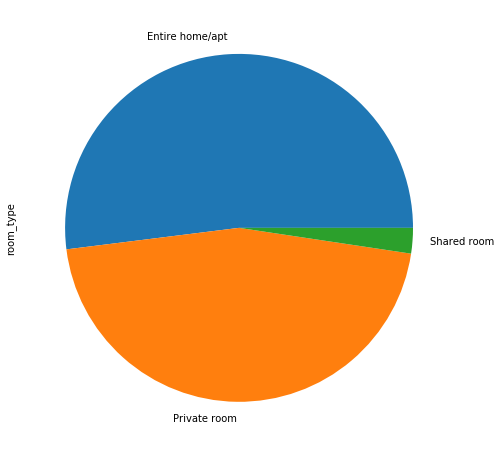

In [765]:
df['room_type'].value_counts().plot(kind='pie', figsize=(8, 8))

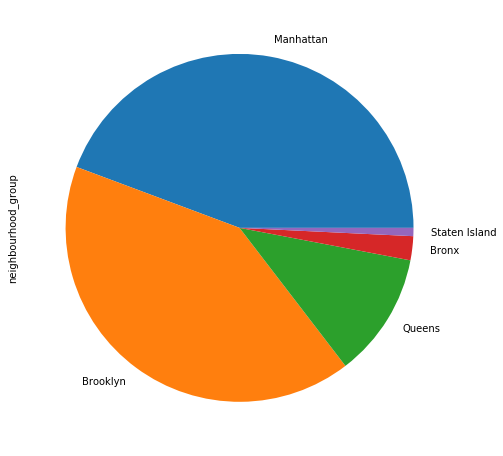

In [766]:
df['neighbourhood_group'].value_counts().plot(kind='pie', figsize=(8, 8))

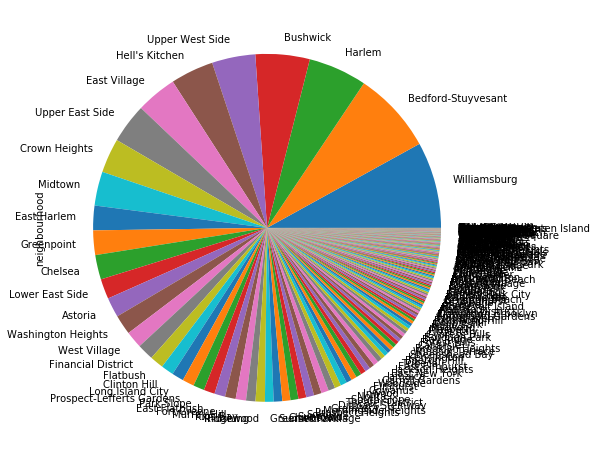

In [767]:
df['neighbourhood'].value_counts().plot(kind='pie', figsize=(8, 8))

Не очень удачная визуализация, но наглядно отображает распределение районов.

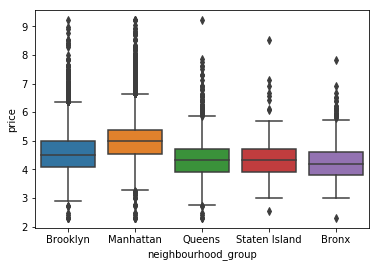

In [768]:
sns.boxplot(x="neighbourhood_group", y="price", data=df)

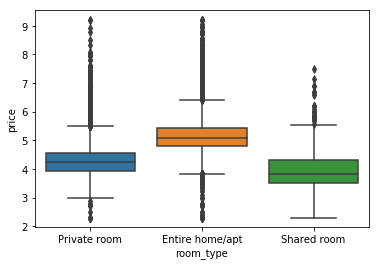

In [769]:
sns.boxplot(x="room_type", y="price", data=df)

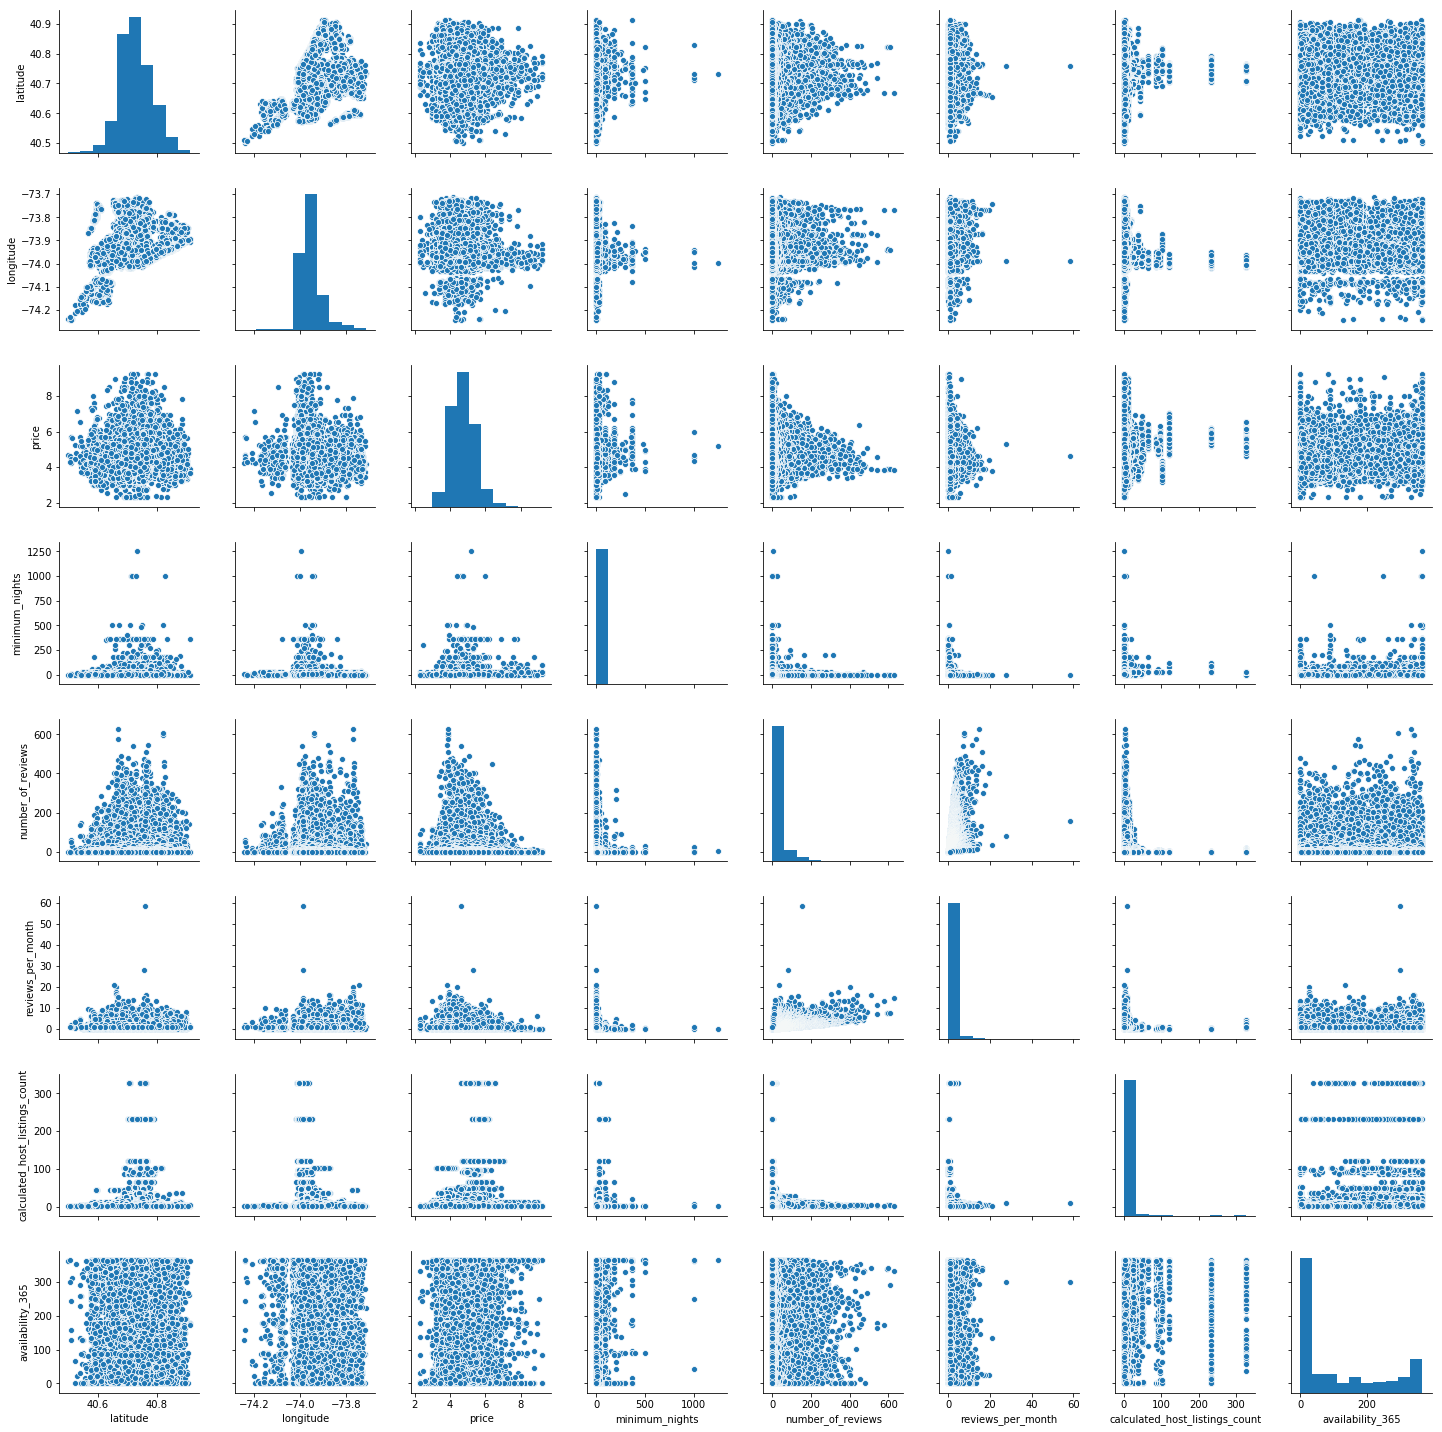

In [678]:
sns.pairplot(df)

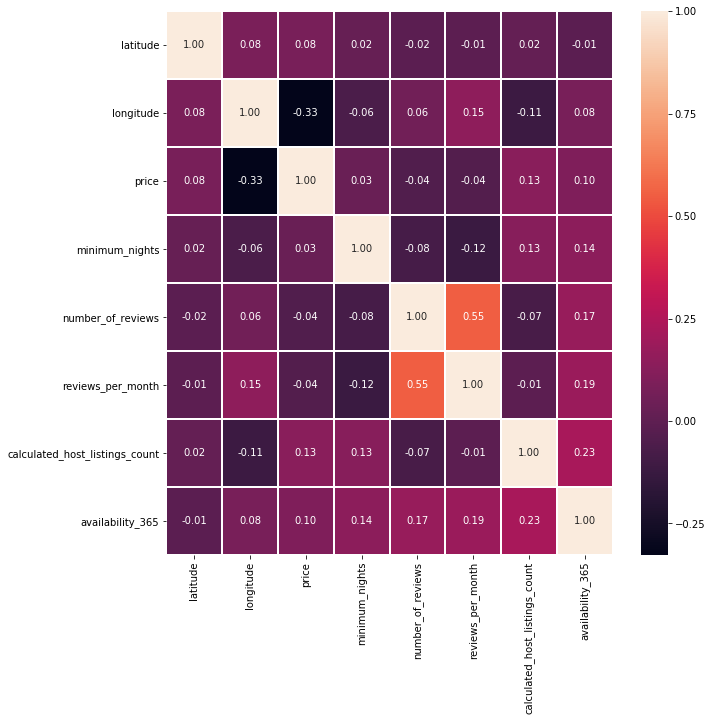

In [679]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df.corr(), annot=True, linewidths=1, fmt='.2f',ax=ax)

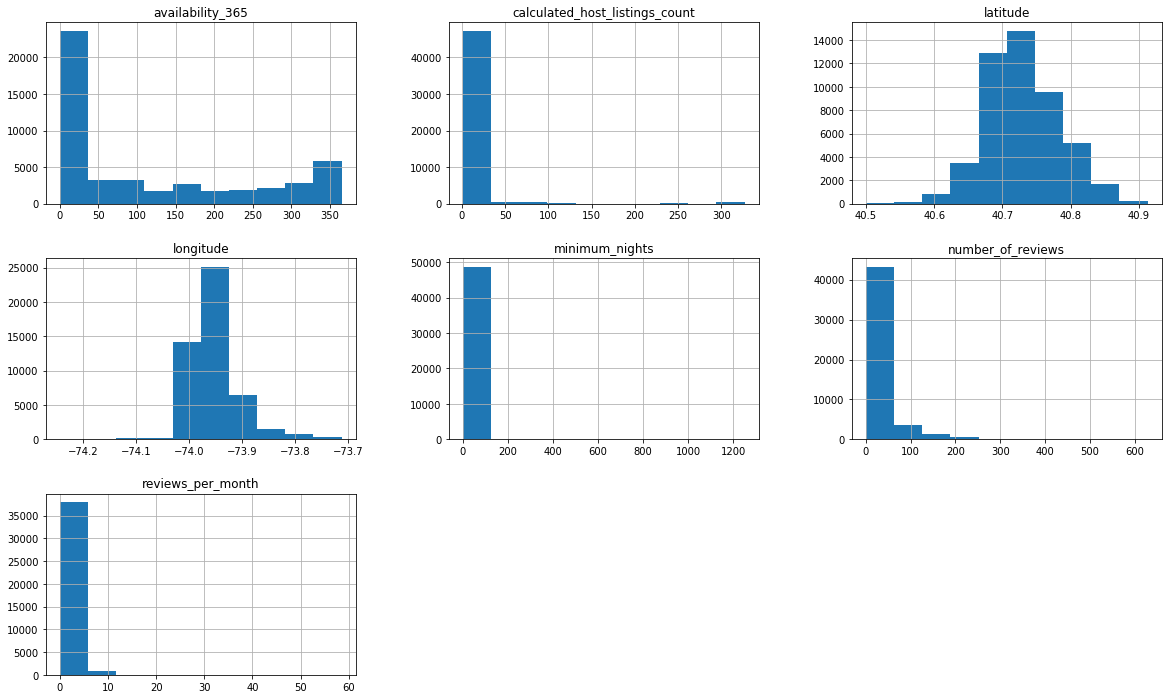

In [680]:
df.drop('price',axis=1).hist(figsize=(20, 12));

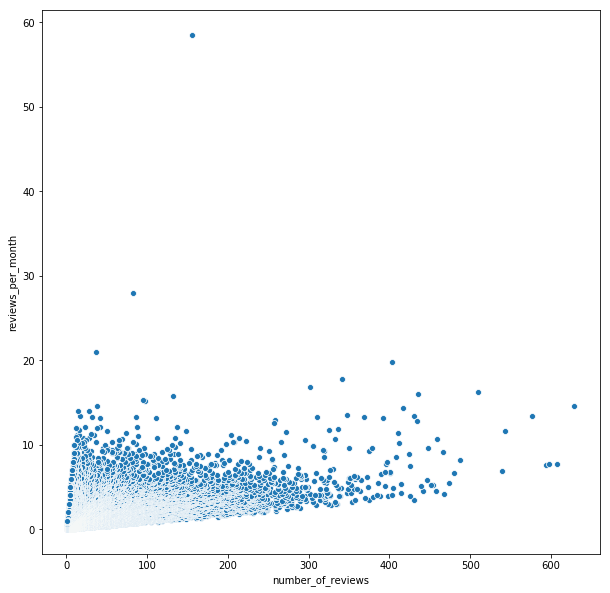

In [681]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.scatterplot(x=df['number_of_reviews'],y=df['reviews_per_month'], ax=ax)

## 3. Обработка пропущенных данных

Необходимо заполнить пропуски данных для признака `reviews_per_month`.

In [873]:
df_reviews = df[[
    'latitude', 'longitude', 'price', 'minimum_nights', 
    'number_of_reviews', 'reviews_per_month', 
    'calculated_host_listings_count', 'availability_365'
]].copy()
df_reviews[:5]

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,5.003946,1,9,0.21,6,365
1,40.75362,-73.98377,5.416100,1,45,0.38,2,355
2,40.80902,-73.94190,5.010635,3,0,NaN,1,365
3,40.68514,-73.95976,4.488636,1,270,4.64,1,194
4,40.79851,-73.94399,4.382027,10,9,0.10,1,0


In [874]:
df_reviews['reviews_per_month'] = np.where(df_reviews['number_of_reviews']!=0, df_reviews['reviews_per_month'],.0)

In [875]:
from sklearn.linear_model import LinearRegression

y_train = df_reviews['reviews_per_month']
X_train = df_reviews.drop('reviews_per_month', axis = 1)
print(X_train.shape)
model_regression = LinearRegression()
model_regression.fit(X_train, y_train)

df_reviews['reviews_per_month_pred'] = model_regression.predict(df_reviews.drop('reviews_per_month', axis = 1))
df['reviews_per_month'] = np.where(~df_reviews['reviews_per_month'].isnull(),df_reviews['reviews_per_month'],df_reviews['reviews_per_month_pred'])
del df_reviews

(48895, 7)


In [876]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null float64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
reviews_per_month                 48895 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64
dtypes: float64(4), int64(4), object(3)
memory usage: 4.1+ MB


Теперь наши данные не содержат пропусков.

## 4. Подготовка датасета

In [877]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

df_clst = df[['neighbourhood','price']].copy()
df_clst



le = preprocessing.LabelEncoder()
df_clst['tr_neighbourhood'] = le.fit_transform(df_clst['neighbourhood'])

kmeans = KMeans(n_clusters=10, random_state=0).fit(X=df_clst[['tr_neighbourhood']],y=df_clst['price'])
# # kmeans.labels_
# # kmeans.predict([[0, 0], [12, 3]])
kmeans.cluster_centers_
kmeans.predict(pd.DataFrame(le.transform(['Midtown'])))

array([5], dtype=int32)

In [878]:
# df = df_copy.copy()
df_neighbourhood_mean_price = df[['neighbourhood','price']].groupby('neighbourhood').mean()

df_neighbourhood_mean_price = df_neighbourhood_mean_price.reset_index()
df_neighbourhood_mean_price.rename(columns={'price':'price_mean_n'}, inplace=True)
df = pd.merge(df,df_neighbourhood_mean_price,how='left',left_on='neighbourhood',right_on='neighbourhood',)
df.drop(columns=['neighbourhood'], inplace=True)
df.rename(columns={'price_mean_n':'neighbourhood'}, inplace=True)

df_dumm = pd.get_dummies(df[['neighbourhood_group','room_type']])

df = pd.concat([df.drop(['neighbourhood_group','room_type'],axis=1),df_dumm], axis=1)
df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,5.003946,1,9,0.21,6,365,4.332537,0,1,0,0,0,0,1,0
1,40.75362,-73.98377,5.416100,1,45,0.38,2,355,5.416535,0,0,1,0,0,1,0,0
2,40.80902,-73.94190,5.010635,3,0,0.00,1,365,4.558922,0,0,1,0,0,0,1,0
3,40.68514,-73.95976,4.488636,1,270,4.64,1,194,4.817752,0,1,0,0,0,1,0,0
4,40.79851,-73.94399,4.382027,10,9,0.10,1,0,4.647989,0,0,1,0,0,1,0,0


In [879]:
center_phi,center_lambda = df['latitude'].median(), df['longitude'].median()
# print(center_phi,center_lambda)
# df_coo = df[['latitude','longitude']]
# df['center_distance'] = df_coo.apply(lambda coo: calculate_distance(coo.latitude,coo.longitude,center_phi,center_lambda),axis=1)

from sklearn.metrics.pairwise import euclidean_distances
df['center_distance'] = euclidean_distances(df[['latitude','longitude']],[[center_phi,center_lambda]])
df.drop(columns=['latitude','longitude'], inplace=True)

In [880]:
df

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,center_distance
0,5.003946,1,9,0.21,6,365,4.332537,0,1,0,0,0,0,1,0,0.077401
1,5.416100,1,45,0.38,2,355,5.416535,0,0,1,0,0,1,0,0,0.041501
2,5.010635,3,0,0.00,1,365,4.558922,0,0,1,0,0,0,1,0,0.087048
3,4.488636,1,270,4.64,1,194,4.817752,0,1,0,0,0,1,0,0,0.038149
4,4.382027,10,9,0.10,1,0,4.647989,0,0,1,0,0,1,0,0,0.076340
5,5.298317,3,74,0.59,1,129,5.243010,0,0,1,0,0,1,0,0,0.031280
6,4.094345,45,49,0.40,1,0,4.434461,0,1,0,0,0,0,1,0,0.036191
7,4.369448,2,430,3.47,1,220,5.126005,0,0,1,0,0,0,1,0,0.051034
8,4.369448,2,118,0.99,1,0,5.023161,0,0,1,0,0,0,1,0,0.079553
9,5.010635,1,160,1.33,4,188,4.914856,0,0,1,0,0,1,0,0,0.036002


In [881]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.3)

In [882]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

scaler.fit(df_train[[
    'minimum_nights','number_of_reviews','reviews_per_month',
    'calculated_host_listings_count','availability_365','neighbourhood','center_distance'
]]) 

StandardScaler(copy=True, with_mean=True, with_std=True)

In [883]:
df_train_scale = scaler.transform(
    df_train[[
        'minimum_nights','number_of_reviews','reviews_per_month',
        'calculated_host_listings_count','availability_365','neighbourhood','center_distance'
    ]]
)

df_test_scale = scaler.transform(
    df_test[[
        'minimum_nights','number_of_reviews','reviews_per_month',
        'calculated_host_listings_count','availability_365','neighbourhood','center_distance'
    ]]
)

In [884]:
df_train[[
    'minimum_nights','number_of_reviews','reviews_per_month',
    'calculated_host_listings_count','availability_365','neighbourhood','center_distance'
]] = df_train_scale

df_test[[
    'minimum_nights','number_of_reviews','reviews_per_month',
    'calculated_host_listings_count','availability_365','neighbourhood','center_distance'
]] = df_test_scale

In [885]:
print(df_train.shape) # Посмотрим на размеры трэйна и теста 
print(df_test.shape) 

(34226, 16)
(14669, 16)


In [886]:
y_train = df_train.price 
y_test = df_test.price 

X_train = df_train.drop('price', axis=1).get_values()
X_test = df_test.drop('price', axis=1).get_values()

## Функции

In [887]:
# def calculate_distance(phiA, lambdaA, phiB, lambdaB):
#     """
#     Расстояние между двумя точками
#     phiA, lambdaA - широта, долгота 1-й точки,
#     phiB, lambdaB - широта, долгота 2-й точки
#     """
    
#     EARTH_RADIUS = 6372795
    
#     # Перевод координат в радианы
#     lat1 = phiA * math.pi / 180
#     lat2 = phiB * math.pi / 180
#     long1 = lambdaA * math.pi / 180
#     long2 = lambdaB * math.pi / 180
 
#     # Косинусы и синусы широт и разницы долгот
#     cl1 = np.cos(lat1)
#     cl2 = np.cos(lat2)
#     sl1 = np.sin(lat1)
#     sl2 = np.sin(lat2)
#     delta = long2 - long1
#     cdelta = np.cos(delta)
#     sdelta = np.sin(delta)
    
#     # Вычисления длины большого круга
#     y = np.sqrt(pow(cl2 * sdelta, 2) + pow(cl1 * sl2 - sl1 * cl2 * cdelta, 2))
#     x = sl1 * sl2 + cl1 * cl2 * cdelta
    
#     ad = np.arctan2(y, x)
#     dist = ad * EARTH_RADIUS
    
#     return np.abs(dist)


 

# lat1 = 77.1539
# long1 = -139.398
# lat2 = -77.1804
# long2 = -139.55
 
# print(calculate_distance(lat1, long1, lat2, long2))
# ## Вернет "17166029 метров"
# np.linalg.norm((lat1, long1)-(lat2, long2))

## 5. Базовая модель

In [888]:
y_mean = np.mean(y_train)
y_pred_naive = np.ones(len(y_test)) * y_mean  
y_pred_naive[:5]

array([4.72508243, 4.72508243, 4.72508243, 4.72508243, 4.72508243])

## 6. Метрики качества

In [889]:
from sklearn import metrics 

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred)))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred))))
    print('R2:',  metrics.r2_score(y_test, y_pred))
    
    # Исключаем данную метрику ввиду того, что есть нулевые значения в целевой переменной
    # print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    pass

print_metrics(y_test, y_pred_naive)

MAE: 84.75265426800267
RMSE: 240.17348185488765
R2: -1.756343862902021e-05


## 4. Построение модели

### 4.1 LinearRegression

In [890]:
from sklearn.linear_model import LinearRegression

model_regression = LinearRegression()

model_regression.fit(X_train, y_train)
y_pred_regr = model_regression.predict(X_test)

In [891]:
print_metrics(y_test, y_pred_regr)

MAE: 61.74857104437092
RMSE: 223.90118978499993
R2: 0.5296140215586294


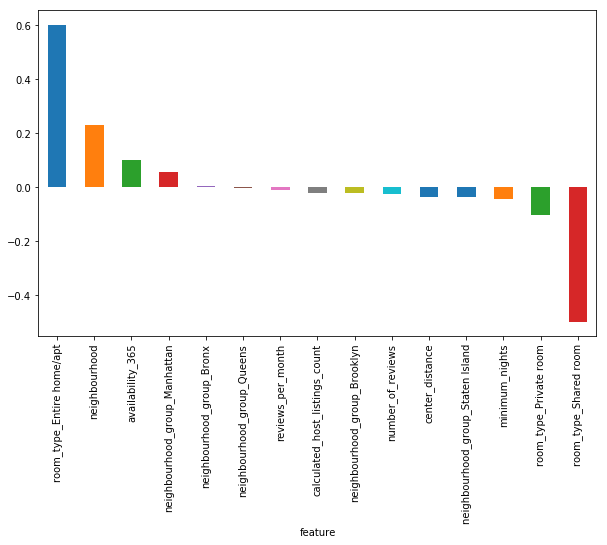

In [892]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": model_regression.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(10, 6));

### 4.2 GridSearchCV

In [929]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Решётака для перебора параметра 
param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}

# Объявили модель 
model_lasso = Lasso() 

# Объявили перебор 
grid_cv_lasso = GridSearchCV(model_lasso, param_grid, cv = 5)
grid_cv_lasso.fit(X_train, y_train)
print('Лучшее значение параметра:', grid_cv_lasso.best_params_)

# Сделали прогнозы
y_pred_lasso = grid_cv_lasso.predict(X_test)

Лучшее значение параметра: {'alpha': 0.0001}


In [930]:
print_metrics(y_test, y_pred_lasso)

MAE: 61.74640135252461
RMSE: 223.90779041112887
R2: 0.5296417247827978


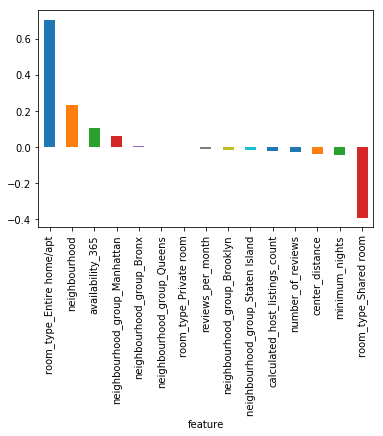

In [908]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": grid_cv_lasso.best_estimator_.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar');

### 4.3 RidgeCV

In [933]:
from sklearn.linear_model import RidgeCV, Ridge

# Решётака для перебора параметра 
param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}

# Объявили модель 
model_ridge = Ridge() 

# >>> X, y = load_diabetes(return_X_y=True)
# >>> clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X, y)
# >>> clf.score(X, y) # doctest: +ELLIPSIS

# Объявили перебор 
ridge_cv_ridge = RidgeCV(alphas=[0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10],store_cv_values=True)
ridge_cv_ridge.fit(X_train, y_train)
print('Лучшее значение параметра:', ridge_cv_ridge.cv_values_[0][0])

# # Сделали прогнозы
y_pred_ridge = ridge_cv_ridge.predict(X_test)

Лучшее значение параметра: 0.04738024765450991


In [934]:
print_metrics(y_test, y_pred_lasso)

MAE: 61.74640135252461
RMSE: 223.90779041112887
R2: 0.5296417247827978


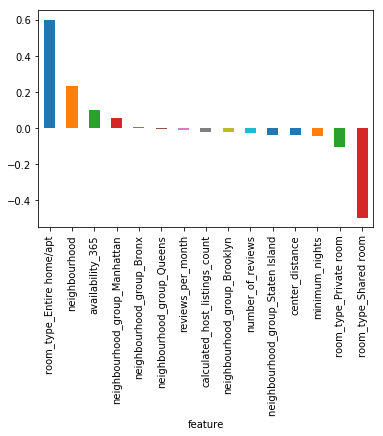

In [935]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": ridge_cv_ridge.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar');

### 4.4 ElasticNetCV

In [938]:
from sklearn.linear_model import ElasticNetCV,ElasticNet

# Решётака для перебора параметра 
param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}

# Объявили модель 
model_elastic = ElasticNet() 

# >>> X, y = load_diabetes(return_X_y=True)
# >>> clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X, y)
# >>> clf.score(X, y) # doctest: +ELLIPSIS

# Объявили перебор 
elastic_cv_elastic = ElasticNetCV(cv=5, random_state=42)
elastic_cv_elastic.fit(X_train, y_train)
print('Лучшее значение параметра:', elastic_cv_elastic.alpha_)

# # Сделали прогнозы
y_pred_elastic = elastic_cv_elastic.predict(X_test)

Лучшее значение параметра: 0.0007350370711704326


In [937]:
print_metrics(y_test, y_pred_elastic)

MAE: 61.73824996866705
RMSE: 223.9349270355343
R2: 0.5297031322120092


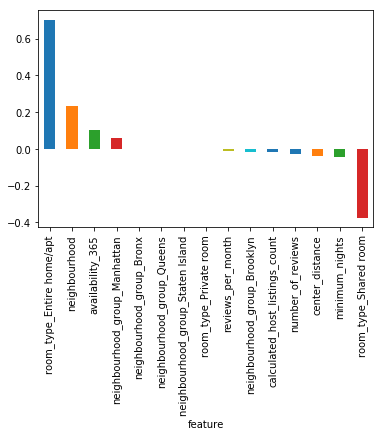

In [939]:
featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": elastic_cv_elastic.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar');